In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import os

In [6]:
from sklearn.datasets import load_files
rev_train = load_files('/Users/yutaro/Documents/source/sutdy_ML_with_python/local/aclImdb/train')
text_train, y_train = rev_train.data, rev_train.target
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [7]:
text_train = [doc.replace(b'<br />', b' ') for doc in text_train]

In [8]:
rev_test = load_files('/Users/yutaro/Documents/source/sutdy_ML_with_python/local/aclImdb/test')
text_test, y_test = rev_test.data, rev_test.target
text_test = [doc.replace(b'<br />', b' ') for doc in text_test]


In [10]:
print(f'train data set : {len(y_train)}')
print(f'train data contents : {np.bincount(y_train)}')
print(f'test data set : {len(y_test)}')
print(f'test data contents : {np.bincount(y_test)}')

train data set : 25000
train data contents : [12500 12500]
test data set : 25000
test data contents : [12500 12500]


# <ins>B</ins>ag <ins>o</ins>f <ins>W</ins>ord

In [11]:
bards_word = [
    'The fool doth think he is wise',
    'but the wise man knows himself to be a fool'
]

In [12]:
from sklearn.feature_extraction.text import  CountVectorizer
vect = CountVectorizer().fit(bards_word)
print(vect.vocabulary_)

{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [16]:
bow = vect.transform(bards_word)
bow

<2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [17]:
bow.toarray()

array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]])

* 映画レビューをやってみる

In [20]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>

In [21]:
vect.get_feature_names_out()

array(['00', '000', '0000000000001', ..., 'østbye', 'über', 'üvegtigris'],
      dtype=object)

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C' : [.001, .01, .1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator = LogisticRegression(max_iter=2000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train,y_train)

print(f'best params = {grid.best_params_}')
print(f'best score = {grid.best_score_:.3f}')

best params = {'C': 0.1}
best score = 0.888


In [26]:
X_test = vect.transform(text_test)
print(f'accuracy for test : {grid.score(X_test,y_test):.3f}')

accuracy for test : 0.879


* 全単語抽出から5つのサンプル未満の登場単語を削除する

In [27]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print(f'X_train with min_df : {repr(X_train)}')


X_train with min_df : <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [28]:
grid = GridSearchCV(
    estimator = LogisticRegression(max_iter=2000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train,y_train)

print(f'best params = {grid.best_params_}')
print(f'best score = {grid.best_score_:.3f}')

best params = {'C': 0.1}
best score = 0.888


* stopwordsの検討

In [29]:
vect = CountVectorizer(min_df=5,stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
# print(f'X_train with min_df : {repr(X_train)}')

grid = GridSearchCV(
    estimator = LogisticRegression(max_iter=2000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train,y_train)

print(f'best params = {grid.best_params_}')
print(f'best score = {grid.best_score_:.3f}')

best params = {'C': 0.1}
best score = 0.883


* TF-IDF Term Frequency - inversed Document Frequency  
CountVectorizerと違ってTF-IDFは統計情報を使った前処理なので、交差検証での検証データが含まれてはだめ

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    TfidfVectorizer(min_df=5,norm=None),
    LogisticRegression(max_iter=2000),
)

estimators = [est for est in pipe.named_steps.keys()]

In [37]:

param_grid = {
    f'{estimators[1]}__C' : [.001, .01, .1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid.fit(text_train,y_train)

print(f'best params = {grid.best_params_}')
print(f'best score = {grid.best_score_:.3f}')

best params = {'logisticregression__C': 0.001}
best score = 0.894


In [39]:
vectorizer = grid.best_estimator_.named_steps[estimators[0]]

In [48]:
len(vectorizer.get_feature_names_out())

27271

In [41]:
X_train = vectorizer.transform(text_train)

<bound method _cs_matrix.toarray of <25000x27271 sparse matrix of type '<class 'numpy.float64'>'
	with 3354014 stored elements in Compressed Sparse Row format>>

In [58]:
tfidf = X_train.max(axis=0).toarray().ravel()
# 単語スパース行列の特徴量(単語)ごとの値は0かTFIDFの値なので、max(axis=0)で単語ごとの最大値を出せばその単語のTFIDFを求められる。
index_sorted_by_tfidf = np.argsort(tfidf)
# tfidfで並び替えたインデックスを取得

* TFiDF小 = 多くの文章に登場する(DFが大きい) and/or 絶対的な出現が少ない(TFが少ない) and/or 長い文章にしか登場しない(L2正則の影響が大きい)  
TFiDF大 = 登場する文書数は多くないが、単語の登場回数自体は多い = 特定の話題において頻用される、特徴的な言葉

In [65]:
words = vectorizer.get_feature_names_out()

print(f'smallest 20 words : \n{words[index_sorted_by_tfidf][:20]}')
print(f'largest 20 words : \n{words[index_sorted_by_tfidf][-20:]}')

smallest 20 words : 
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
largest 20 words : 
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


In [69]:
# inversed Document Frequency = その単語が登場する文書が全体のうちどのくらいあるかの逆数
# vectorizer.idf_でアクセス可能。単語ごとの数値のアレイで取得
index_sorted_by_idf = np.argsort(vectorizer.idf_)
print(f'smallest idf 50 words :\n{words[index_sorted_by_idf][:50]}')

smallest idf 50 words :
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very']


In [74]:
classifier = grid.best_estimator_.named_steps[estimators[1]]
coef = classifier.coef_.ravel()
index = np.argsort(coef)
bottom40_words = words[index[:40]]
bottom40_coef = coef[index[:40]]
top40_words = words[index[-40:]]
top40_coef = coef[index[-40:]]

Text(0, 0.5, 'Coeficient of logisticlegression')

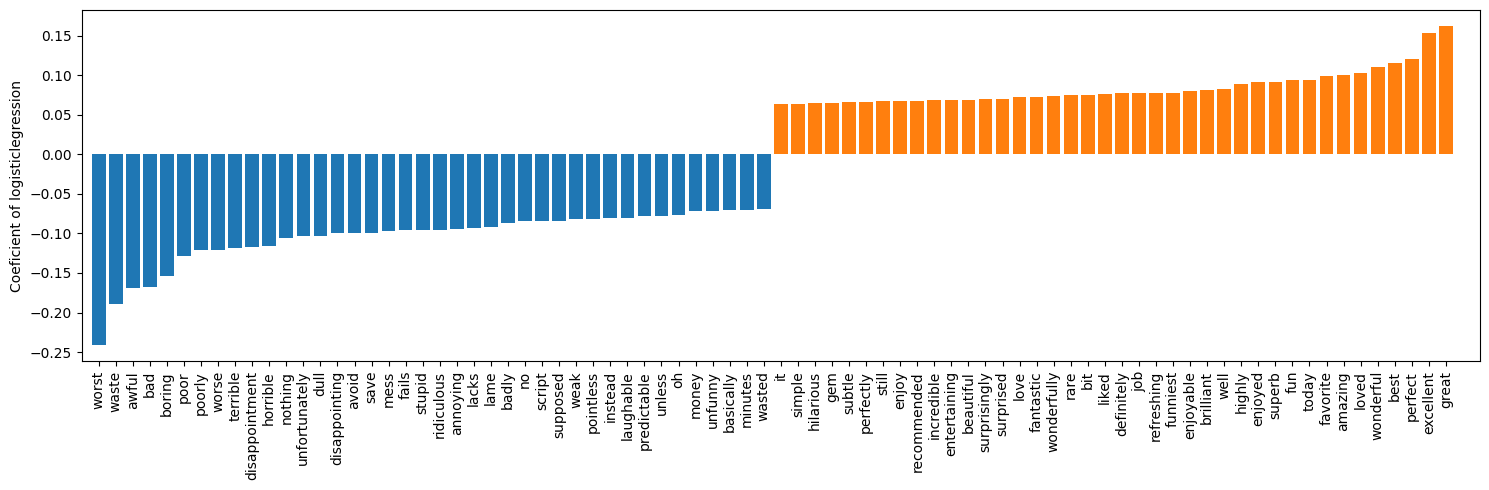

In [88]:
fig,ax = plt.subplots(figsize=(15,5),tight_layout=True)

ax.bar(x=bottom40_words,height=bottom40_coef)
ax.bar(x=top40_words,height=top40_coef)
ax.set_xlim(-1,len(top40_words)+len(bottom40_words)+1)
ax.tick_params(axis='x',rotation=90)
ax.set_ylabel('Coeficient of logisticlegression')

In [89]:
param_grid = {
    f'{estimators[1]}__C' : [.001, .01, .1, 1, 10, 100],
    f'{estimators[0]}__ngram_range' : [(1,1),(1,2),(1,3)],
}

grid = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid.fit(text_train,y_train)

print(f'best params = {grid.best_params_}')
print(f'best cv score = {grid.best_score_:.3f}')

/Users/yutaro/Documents/source/sutdy_ML_with_python/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best params = {'logisticregression__C': 0.001, 'tfidfvectorizer__ngram_range': (1, 3)}
best cv score = 0.906


In [95]:
scores = grid.cv_results_
df = pd.DataFrame(scores)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_logisticregression__C', 'param_tfidfvectorizer__ngram_range',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

<Axes: xlabel='param_logisticregression__C', ylabel='param_tfidfvectorizer__ngram_range'>

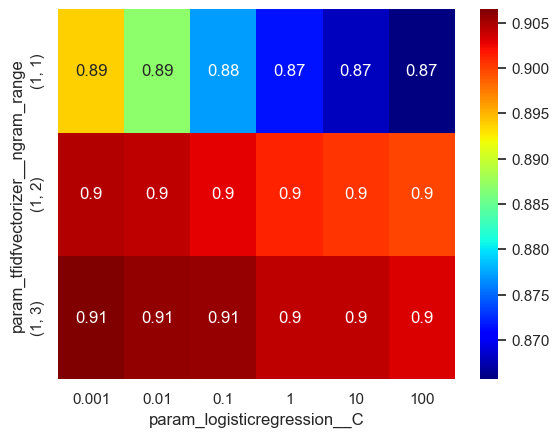

In [100]:
import seaborn as sns
sns.set()
sns.heatmap(
    df.pivot(index='param_tfidfvectorizer__ngram_range', columns='param_logisticregression__C' , values='mean_test_score'),
    cmap='jet',
    annot=True
)

Text(0, 0.5, 'Coeficient of logisticlegression')

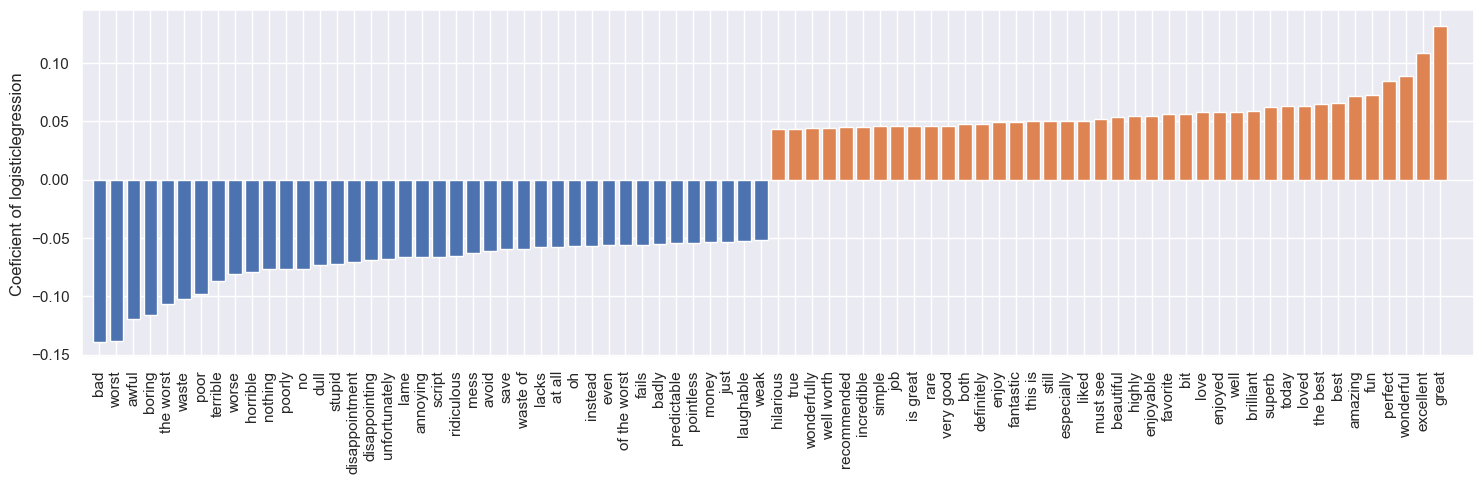

In [102]:
vectorizer = grid.best_estimator_.named_steps[estimators[0]]
classifier = grid.best_estimator_.named_steps[estimators[1]]
words = vectorizer.get_feature_names_out()
coef = classifier.coef_.ravel()
index = np.argsort(coef)
bottom40_words = words[index[:40]]
bottom40_coef = coef[index[:40]]
top40_words = words[index[-40:]]
top40_coef = coef[index[-40:]]

fig,ax = plt.subplots(figsize=(15,5),tight_layout=True)

ax.bar(x=bottom40_words,height=bottom40_coef)
ax.bar(x=top40_words,height=top40_coef)
ax.set_xlim(-1,len(top40_words)+len(bottom40_words)+1)
ax.tick_params(axis='x',rotation=90)
ax.set_ylabel('Coeficient of logisticlegression')

Text(0.5, 0, 'Coeficient of logisticlegression')

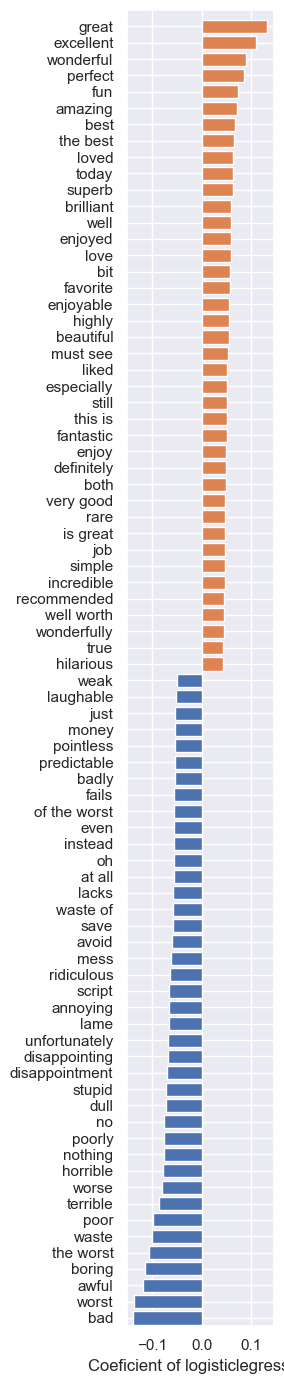

In [108]:
fig,ax = plt.subplots(figsize=(3,14),tight_layout=True)

ax.barh(y=bottom40_words,width=bottom40_coef)
ax.barh(y=top40_words,width=top40_coef)
ax.set_ylim(-0.5,len(top40_words)+len(bottom40_words))
# ax.tick_params(axis='x',rotation=90)
ax.set_xlabel('Coeficient of logisticlegression')

In [115]:
vectorizer = grid.best_estimator_.named_steps[estimators[0]]
classifier = grid.best_estimator_.named_steps[estimators[1]]
mask = np.array([len(word.split(' ')) for word in words])==3
words = vectorizer.get_feature_names_out()[mask]
coef = classifier.coef_.ravel()[mask]
index = np.argsort(coef)
bottom40_words = words[index[:40]]
bottom40_coef = coef[index[:40]]
top40_words = words[index[-40:]]
top40_coef = coef[index[-40:]]

Text(0.5, 0, 'Coeficient of logisticlegression')

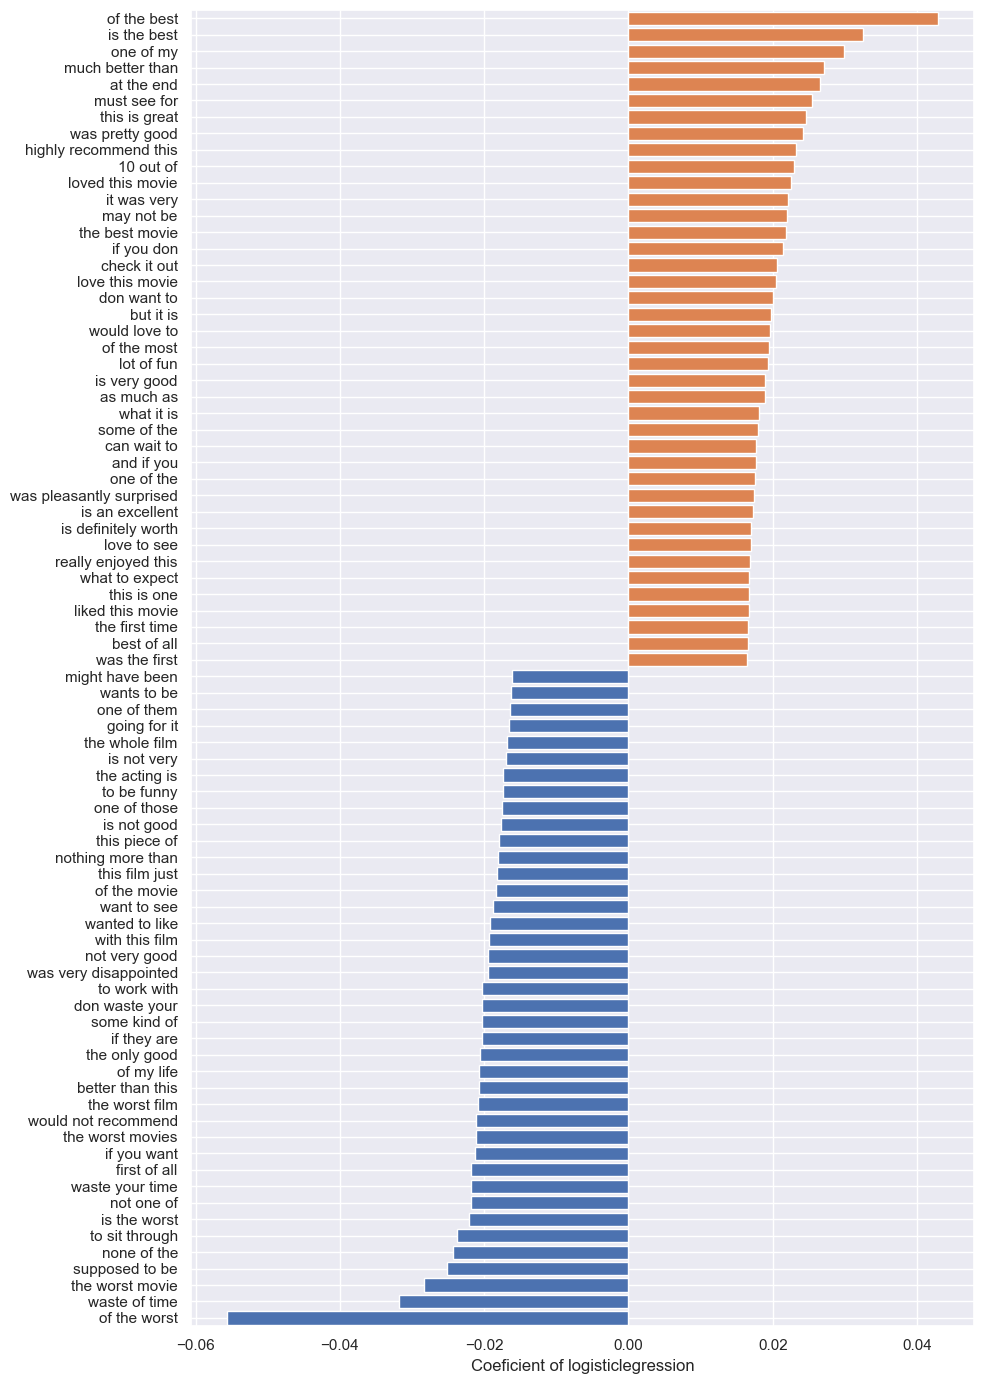

In [118]:
fig,ax = plt.subplots(figsize=(10,14),tight_layout=True)

ax.barh(y=bottom40_words,width=bottom40_coef)
ax.barh(y=top40_words,width=top40_coef)
ax.set_ylim(-0.5,len(top40_words)+len(bottom40_words)-0.5)
# ax.tick_params(axis='x',rotation=90)
ax.set_xlabel('Coeficient of logisticlegression')